# Generating h3 Hexgrids from GeoDataFrames

In [1]:
import geopandas as gpd
import libpysal
import matplotlib.pyplot as plt
import pandas

from tobler.area_weighted import area_interpolate
from tobler.util import h3fy

%load_ext watermark
%watermark -v -a "author: eli knaap" -d -u -p tobler,cenpy,geopandas

Author: author: eli knaap

Last updated: 2021-01-18

Python implementation: CPython
Python version       : 3.8.6
IPython version      : 7.19.0

tobler   : 0.5.4
cenpy    : 1.0.0.post4
geopandas: 0.8.1



**Note**: This notebook relies on functionality from the [`contextily`](https://contextily.readthedocs.io/en/latest/) package that provides convenient basemaps for geospatial plots, and the [`cenpy`](https://cenpy-devs.github.io/cenpy/) package that provide a convenient interface to the U.S. Census API. These can be installed with  
  
`pip install contextily cenpy`     
or    
`conda install contextily cenpy -c conda-forge`

In [2]:
import contextily as ctx
from cenpy import products

## Getting data from CenPy

To begin with, we will fetch some data from the 2017 ACS

In [3]:
acs = products.ACS(2017)

We're looking for median home value, so first we will filter the ACS tables by those containing "value" in the description so we can find the correct variable code

In [4]:
acs.filter_tables("VALUE", by="description")

description  \
table_name                                                      
B25075                                                  VALUE   
B25076                         LOWER VALUE QUARTILE (DOLLARS)   
B25077                                 MEDIAN VALUE (DOLLARS)   
B25078                         UPPER VALUE QUARTILE (DOLLARS)   
B25079        AGGREGATE VALUE (DOLLARS) BY AGE OF HOUSEHOLDER   
B25080        AGGREGATE VALUE (DOLLARS) BY UNITS IN STRUCTURE   
B25082           AGGREGATE VALUE (DOLLARS) BY MORTGAGE STATUS   
B25083                MEDIAN VALUE (DOLLARS) FOR MOBILE HOMES   
B25096                               MORTGAGE STATUS BY VALUE   
B25097              MORTGAGE STATUS BY MEDIAN VALUE (DOLLARS)   
B25100      MORTGAGE STATUS BY RATIO OF VALUE TO HOUSEHOLD...   
B25107                   MEDIAN VALUE BY YEAR STRUCTURE BUILT   
B25108      AGGREGATE VALUE (DOLLARS) BY YEAR STRUCTURE BUILT   
B25109       MEDIAN VALUE BY YEAR HOUSEHOLDER MOVED INTO UNIT   
B25110      AGGREGATE VALUE (DOLLARS) BY YEAR HOUSEHOLDER ...   
B25121      HOUSEHOLD INCOME IN THE PAST 12 MONTHS (IN 201...   
B992519                                   ALLOCATION OF VALUE   

                                                      columns  
table_name                                                     
B25075      [B25075_001E, B25075_002E, B25075_003E, B25075...  
B25076                                          [B25076_001E]  
B25077                                          [B25077_001E]  
B25078                                          [B25078_001E]  
B25079      [B25079_001E, B25079_002E, B25079_003E, B25079...  
B25080      [B25080_001E, B25080_002E, B25080_003E, B25080...  
B25082                [B25082_001E, B25082_002E, B25082_003E]  
B25083                                          [B25083_001E]  
B25096      [B25096_001E, B25096_002E, B25096_003E, B25096...  
B25097                [B25097_001E, B25097_002E, B25097_003E]  
B25100      [B25100_001E, B25100_002E, B25100_003E, B25100...  
B25107      [B25107_001E, B25107_002E, B25107_003E, B25107...  
B25108      [B25108_001E, B25108_002E, B25108_003E, B25108...  
B25109      [B25109_001E, B25109_002E, B25109_003E, B25109...  
B25110      [B25110_001E, B25110_002E, B25110_003E, B25110...  
B25121      [B25121_001E, B25121_002E, B25121_003E, B25121...  
B992519            [B992519_001E, B992519_002E, B992519_003E]

The variable we're looking for is `B25077_001E`, the median home value of each. Lets collect that data for the Washington DC metropolitan region. The next cell can take a minute or two to run, depending on the speed of your connection.

In [5]:
dc = acs.from_msa("Washington-Arlington", variables=["B25077_001E"])

/Users/knaaptime/anaconda3/envs/tobler/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [6]:
dc.head()

GEOID                                           geometry  \
0  51047930501  POLYGON ((-8697543.430 4642311.970, -8697525.0...   
1  51043010100  POLYGON ((-8692606.860 4745175.960, -8692597.2...   
2  51107610701  POLYGON ((-8656718.120 4739943.880, -8656659.1...   
3  51177020408  POLYGON ((-8654861.430 4622579.010, -8654714.2...   
4  51061930402  POLYGON ((-8657404.180 4678713.200, -8657386.4...   

   B25077_001E                                               NAME state  \
0     277000.0    Census Tract 9305.01, Culpeper County, Virginia    51   
1     319600.0          Census Tract 101, Clarke County, Virginia    51   
2     461500.0     Census Tract 6107.01, Loudoun County, Virginia    51   
3     241500.0  Census Tract 204.08, Spotsylvania County, Virg...    51   
4     402000.0    Census Tract 9304.02, Fauquier County, Virginia    51   

  county   tract  
0    047  930501  
1    043  010100  
2    107  610701  
3    177  020408  
4    061  930402

## Creating Hexgrids with the `h3fy` function

Using the `h3fy` function from the `tobler.util` module, we can easily generate a hexgrid covering the face of the DC Metropolitan region

In [7]:
dc_hex = h3fy(dc)

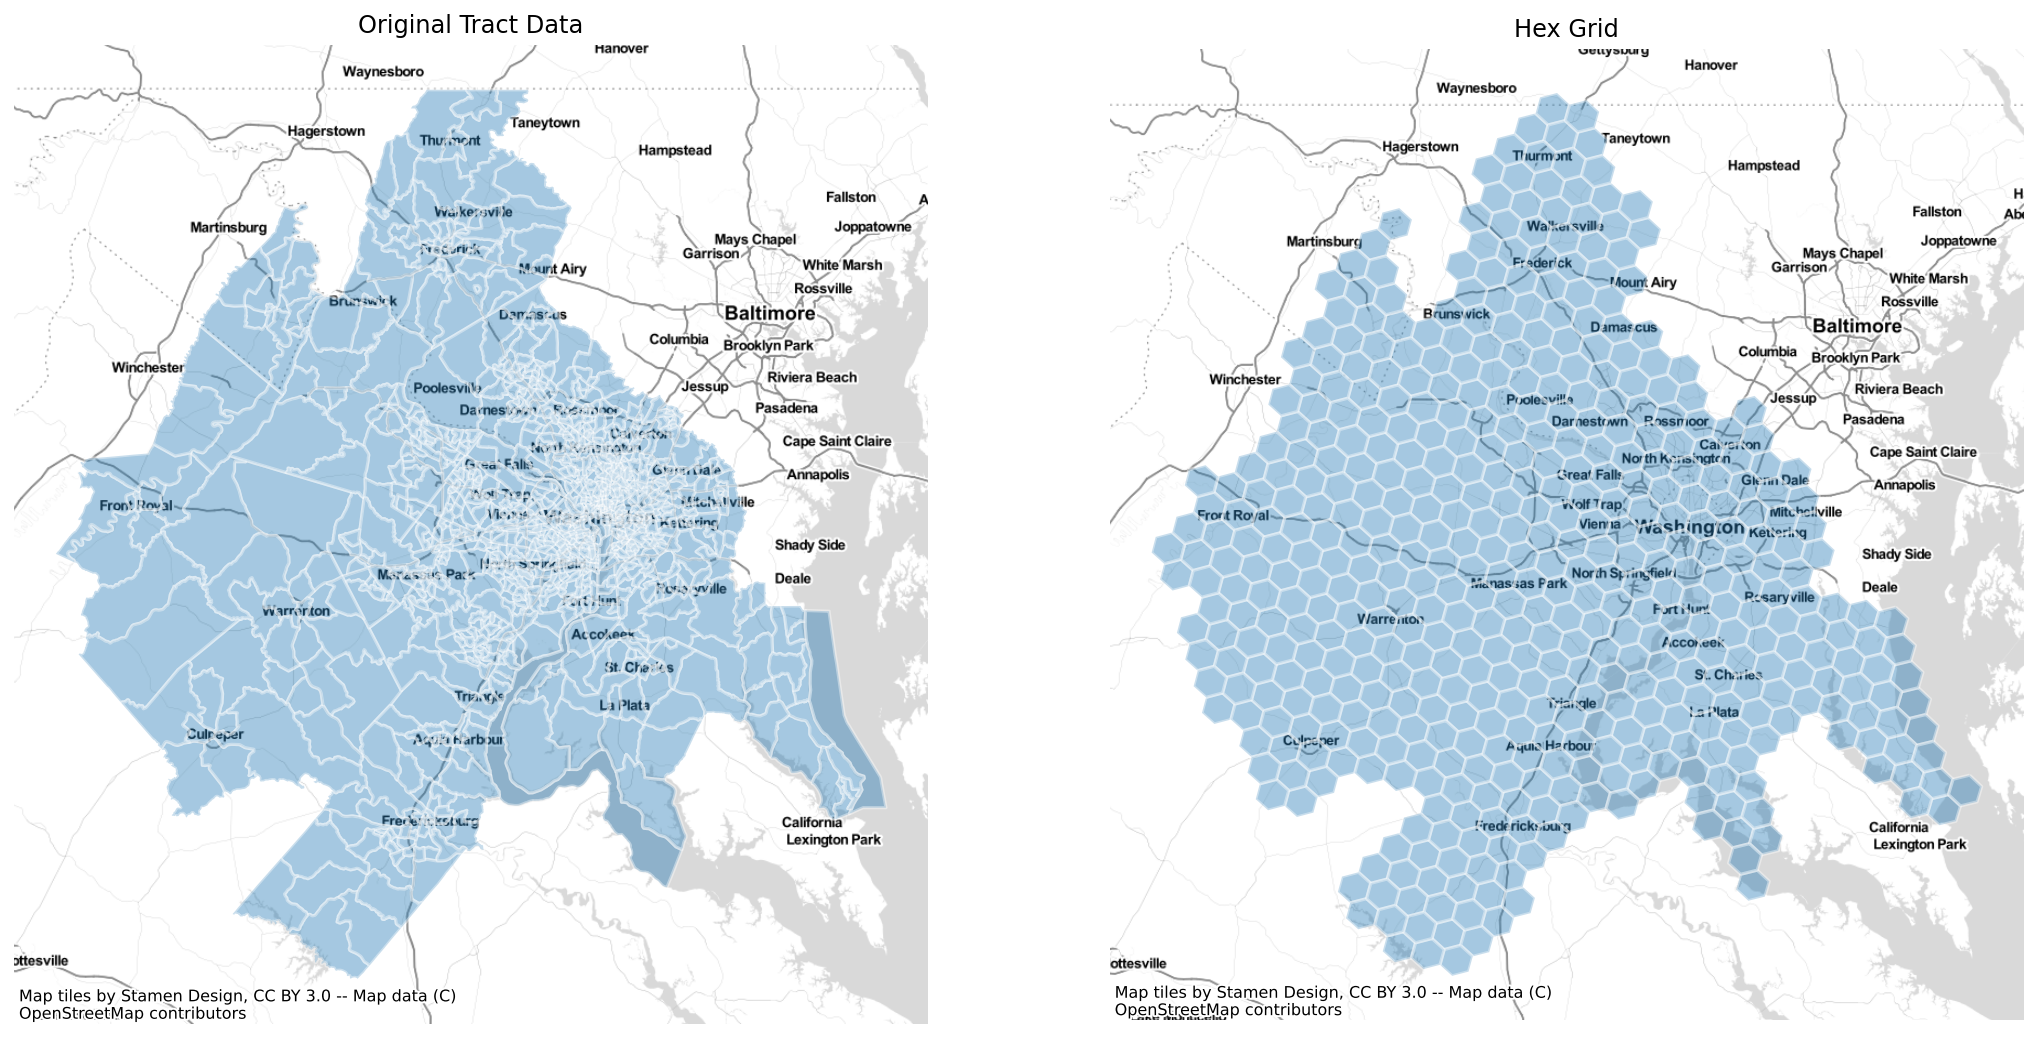

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(18, 10))
axs = axs.flatten()

dc.plot(ax=axs[0], alpha=0.4, linewidth=1.6, edgecolor="white")
dc_hex.plot(ax=axs[1], alpha=0.4, linewidth=1.6, edgecolor="white")

axs[0].set_title("Original Tract Data")
axs[1].set_title("Hex Grid")

for i, _ in enumerate(axs):
    ctx.add_basemap(axs[i], source=ctx.providers.Stamen.TonerLite)
    axs[i].axis("off")

By altering the `resolution` parameter, we can generate grids using hexes of various sizes

In [9]:
dc_hex_large = h3fy(dc, resolution=5)
dc_hex_small = h3fy(dc, resolution=7)

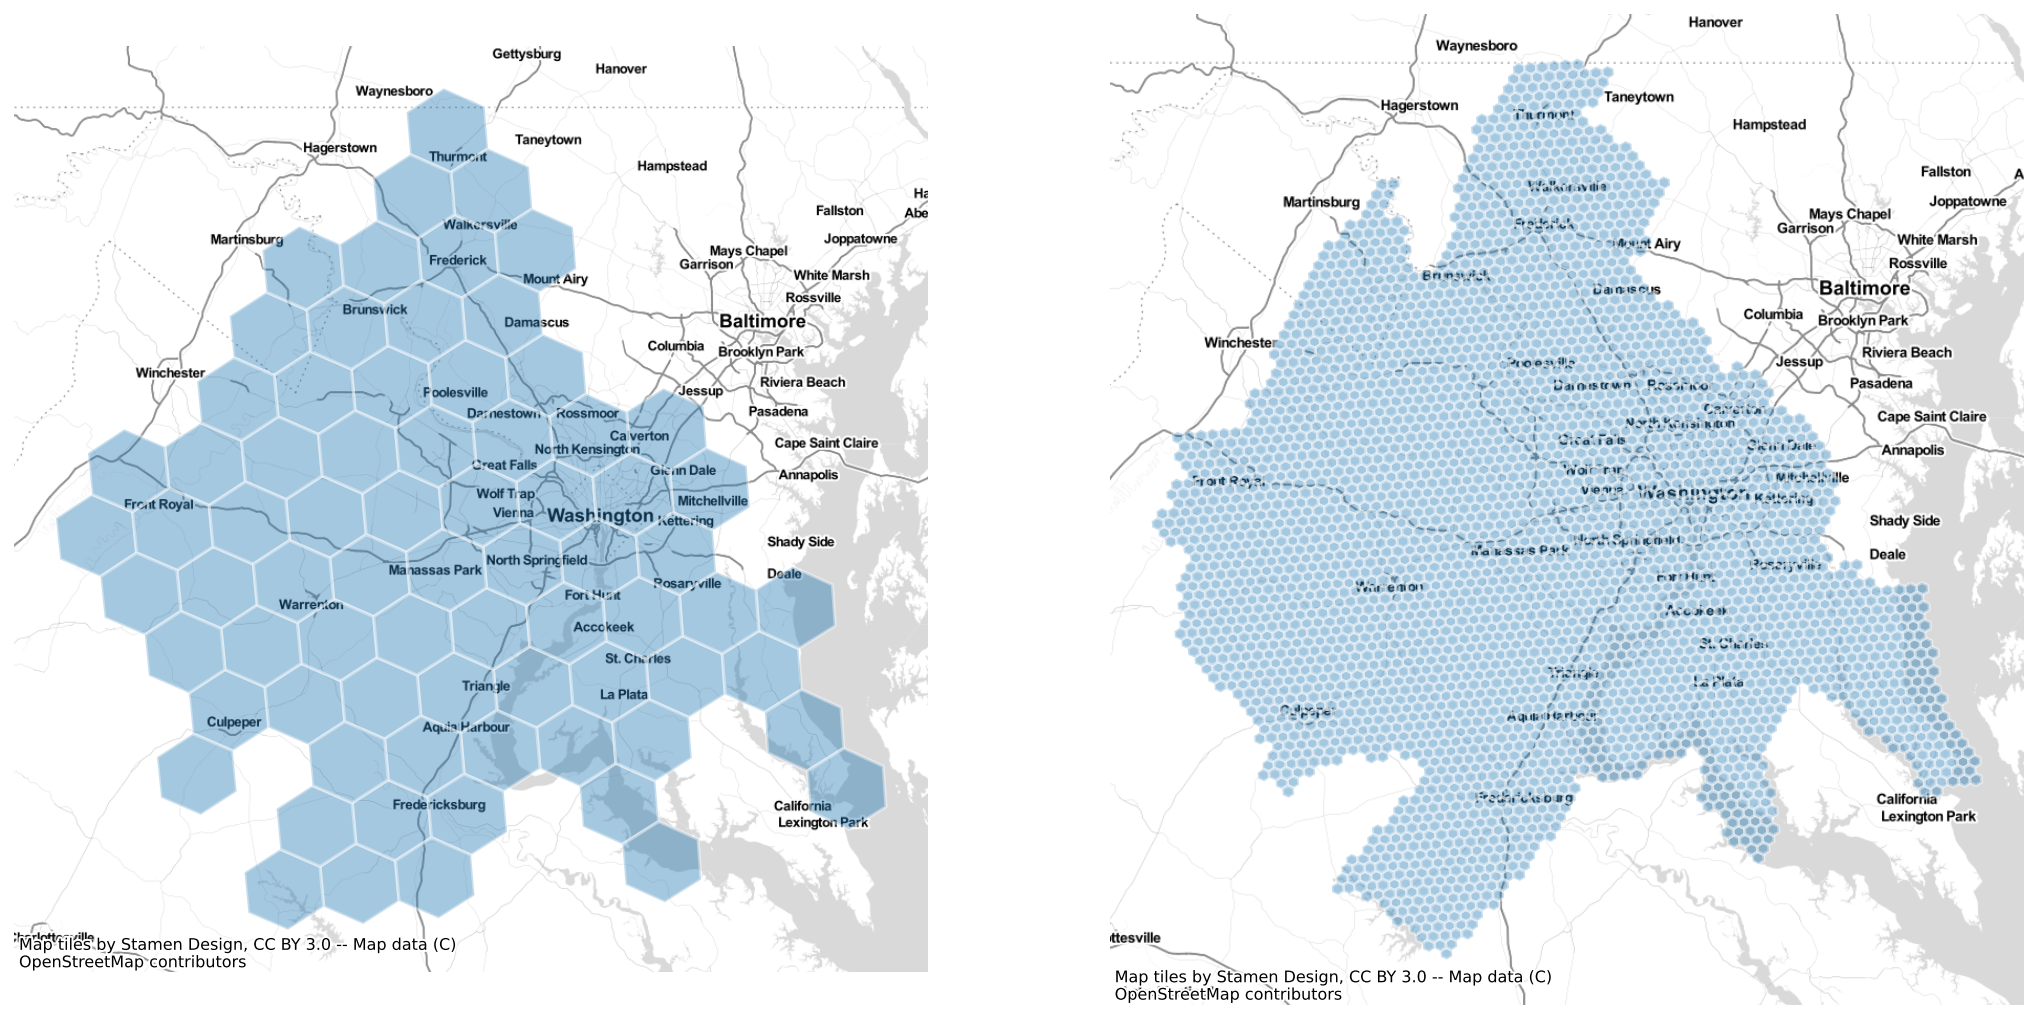

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(18, 10))

dc_hex_large.plot(ax=axs[0], alpha=0.4, linewidth=1.6, edgecolor="white")
dc_hex_small.plot(ax=axs[1], alpha=0.4, linewidth=1.6, edgecolor="white")

for ax in axs:
    ctx.add_basemap(ax=ax, source=ctx.providers.Stamen.TonerLite)
    ax.axis("off")

and by using the `clip` parameter, we can ensure that the hexgrid is does not extend beyond the borders of the input geodataframe

In [11]:
dc_hex_clipped = h3fy(dc, resolution=5, clip=True)

(-8738395.66, -8484578.799999999, 4575391.257202434, 4837245.453466552)

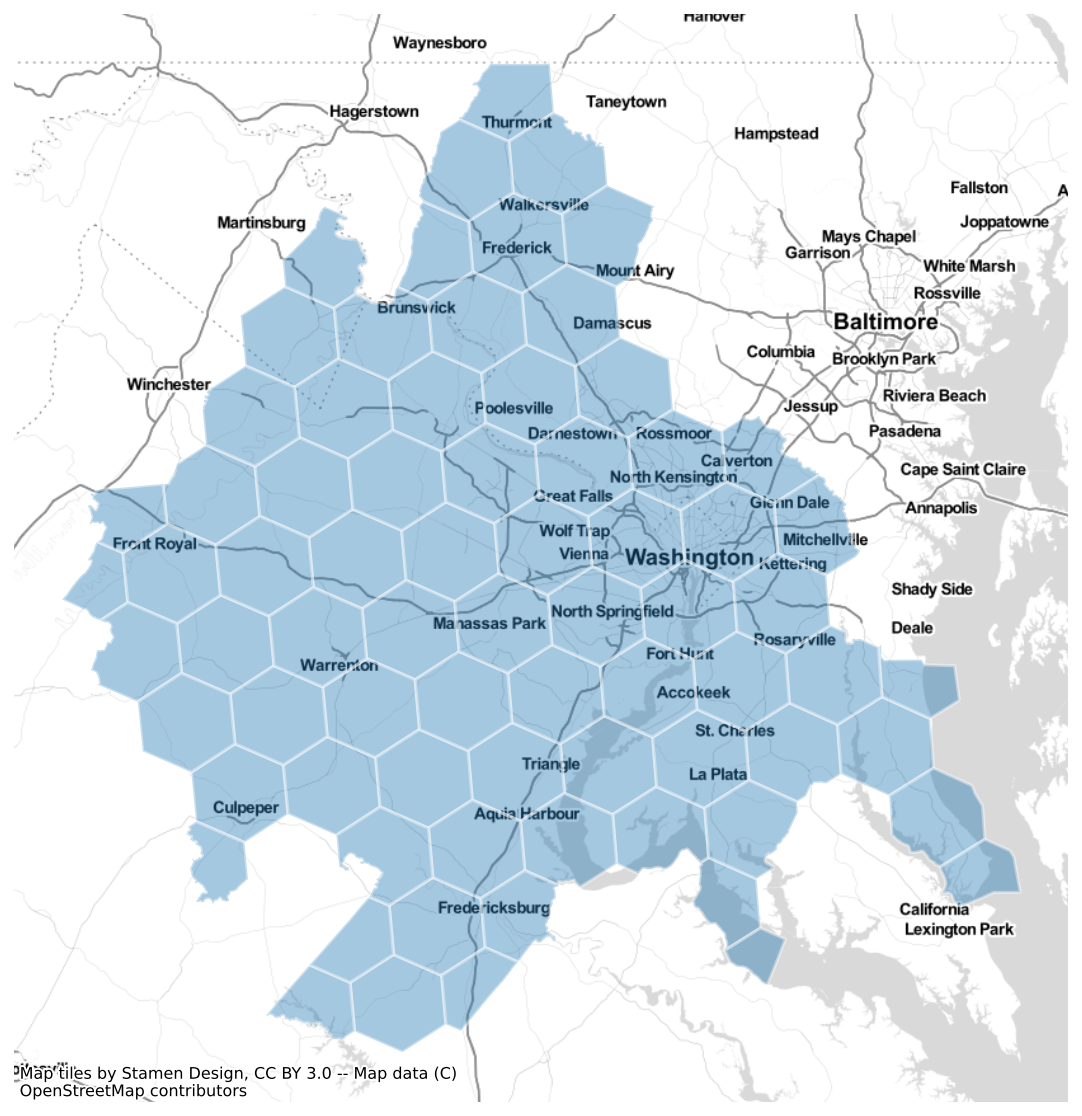

In [12]:
fig, ax = plt.subplots(figsize=(10, 10))

dc_hex_clipped.plot(ax=ax, alpha=0.4, linewidth=1.6, edgecolor="white")
ctx.add_basemap(ax=ax, source=ctx.providers.Stamen.TonerLite)
ax.axis("off")

## Interpolating to a hexgrid

Thus, in just a few lines of code, we can estimate the value of census variables represented by a regular hexgrid

here, we will estimate the median home value of each hex in the DC region using simple areal interpolation

In [13]:
dc_hex_interpolated = area_interpolate(
    source_df=dc, target_df=dc_hex, intensive_variables=["B25077_001E"]
)

/Users/knaaptime/Dropbox/projects/tobler/tobler/util/util.py:32: UserWarning: nan values in variable: B25077_001E, replacing with 0
  warn(f"nan values in variable: {column}, replacing with 0")


Text(0.5, 0.98, 'Spatial Interpolation with the PySAL $\\mathtt{tobler}$ package')

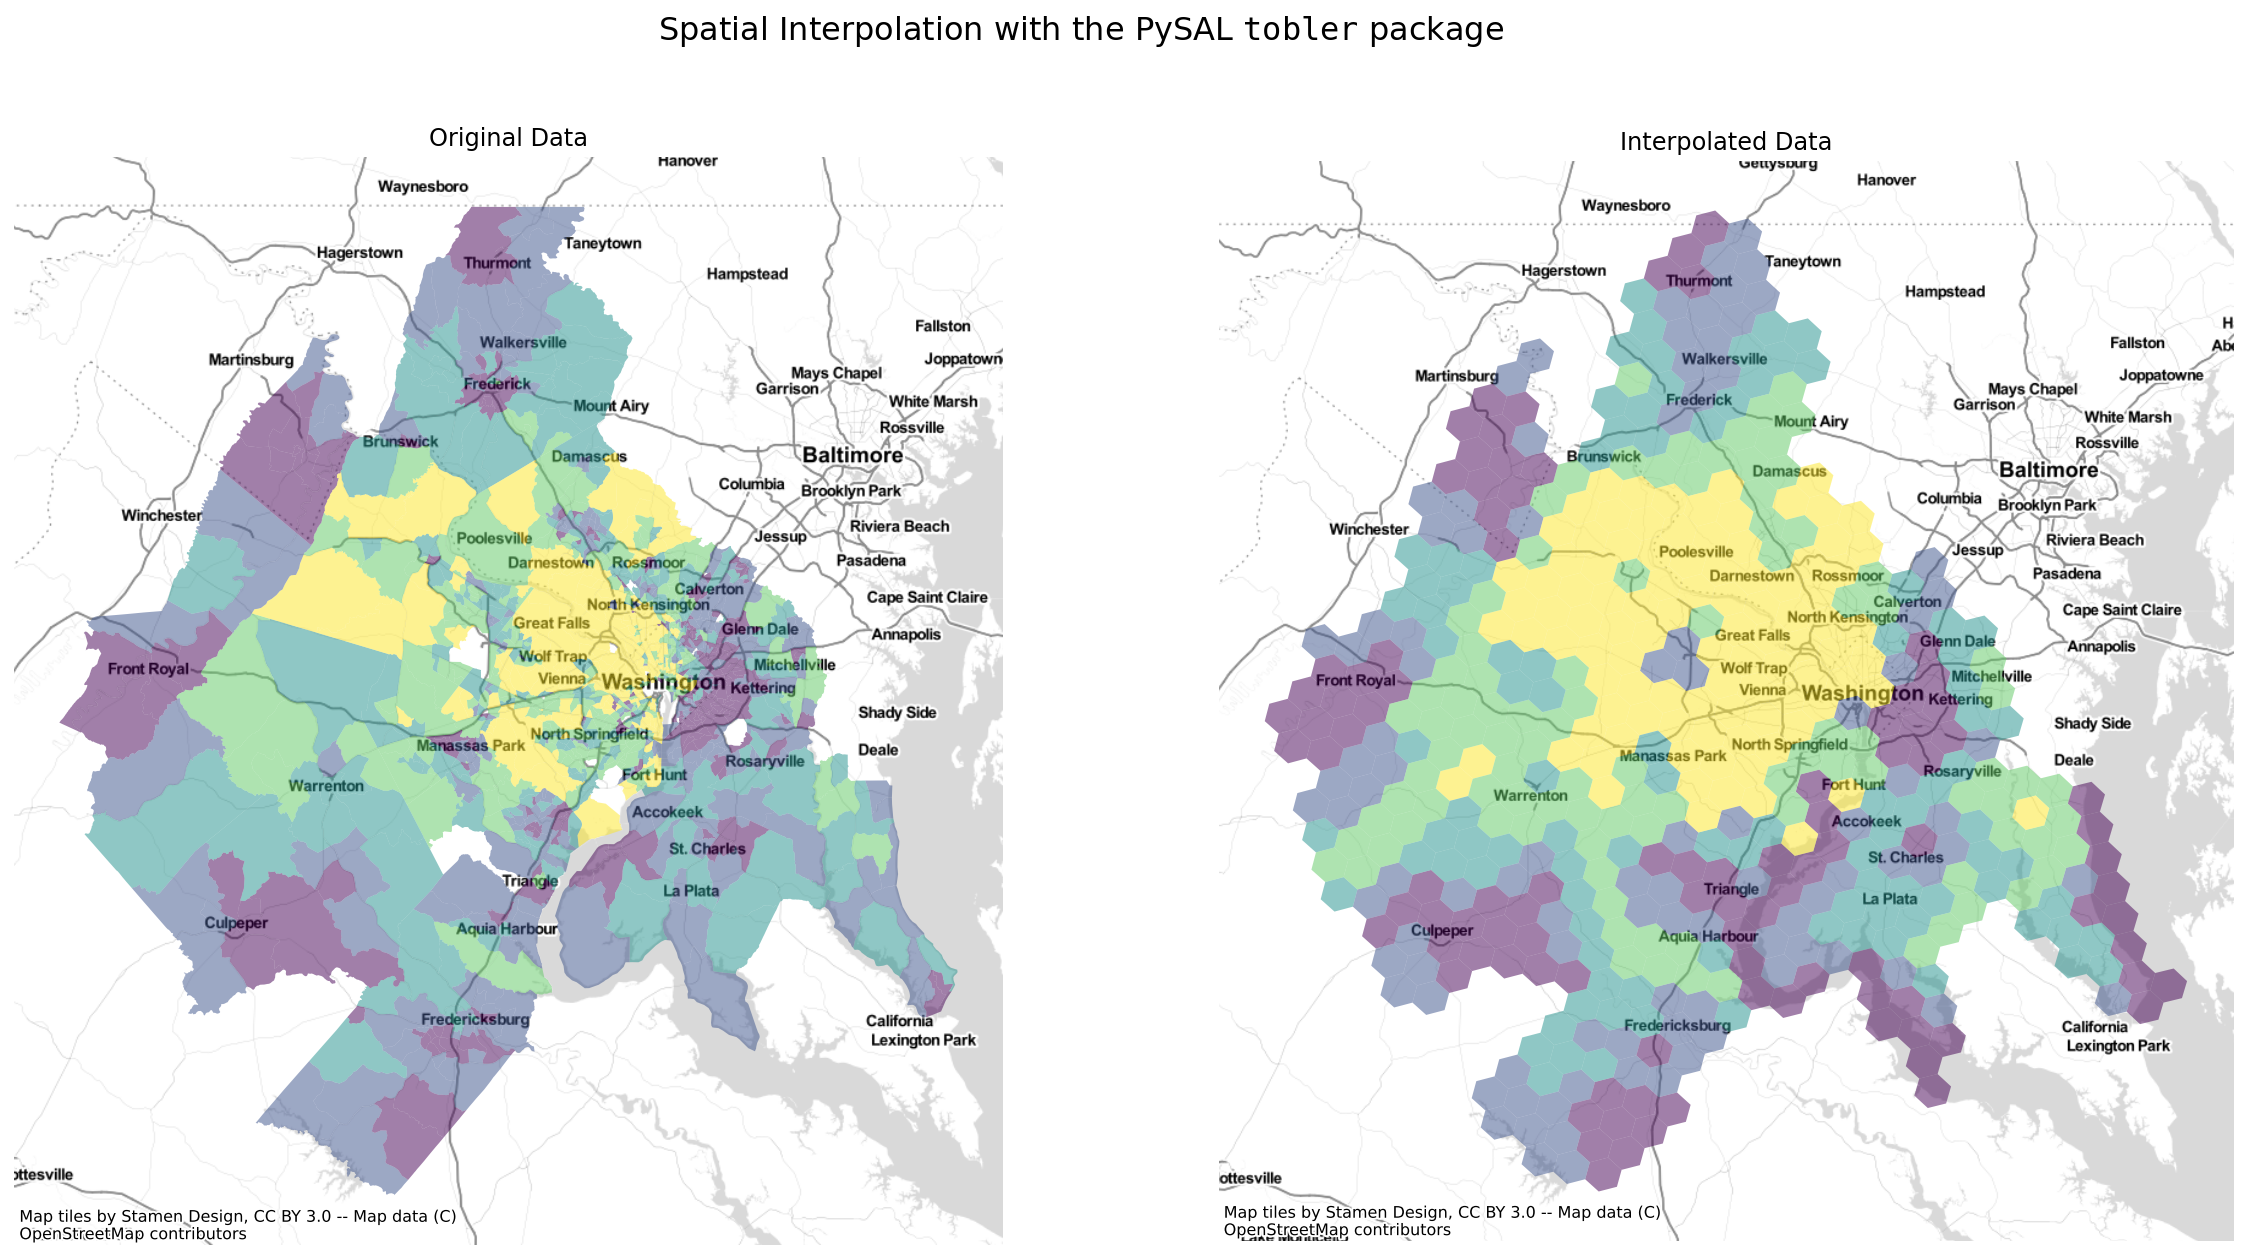

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
dc.plot("B25077_001E", scheme="quantiles", alpha=0.5, ax=axs[0])

dc_hex_interpolated.plot("B25077_001E", scheme="quantiles", alpha=0.5, ax=axs[1])

axs[0].set_title("Original Data")
axs[1].set_title("Interpolated Data")

for ax in axs:
    ctx.add_basemap(ax=ax, source=ctx.providers.Stamen.TonerLite)
    ax.axis("off")
plt.suptitle(
    r"Spatial Interpolation with the PySAL $\mathtt{tobler}$ package", fontsize=16
)